In [1]:
import scanpy as sc
import progeny
import pandas as pd
from statsmodels.stats.multitest import multipletests
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns

sc.set_figure_params(figsize=(5, 5))

## Load data

In [2]:
adata = sc.read_h5ad("../../data/30_merge_adata/adata_scvi.h5ad")

In [3]:
adata.obs.columns

Index(['patient', 'timepoint', 'sample', 'n_genes_by_counts', 'total_counts',
       'total_counts_mito', 'pct_counts_mito', 'n_counts', 'n_genes',
       'patient_id', 'sex', 'age', 'ethnicity', 'response', 'leiden',
       'leiden_scvi', 'cell_type'],
      dtype='object')

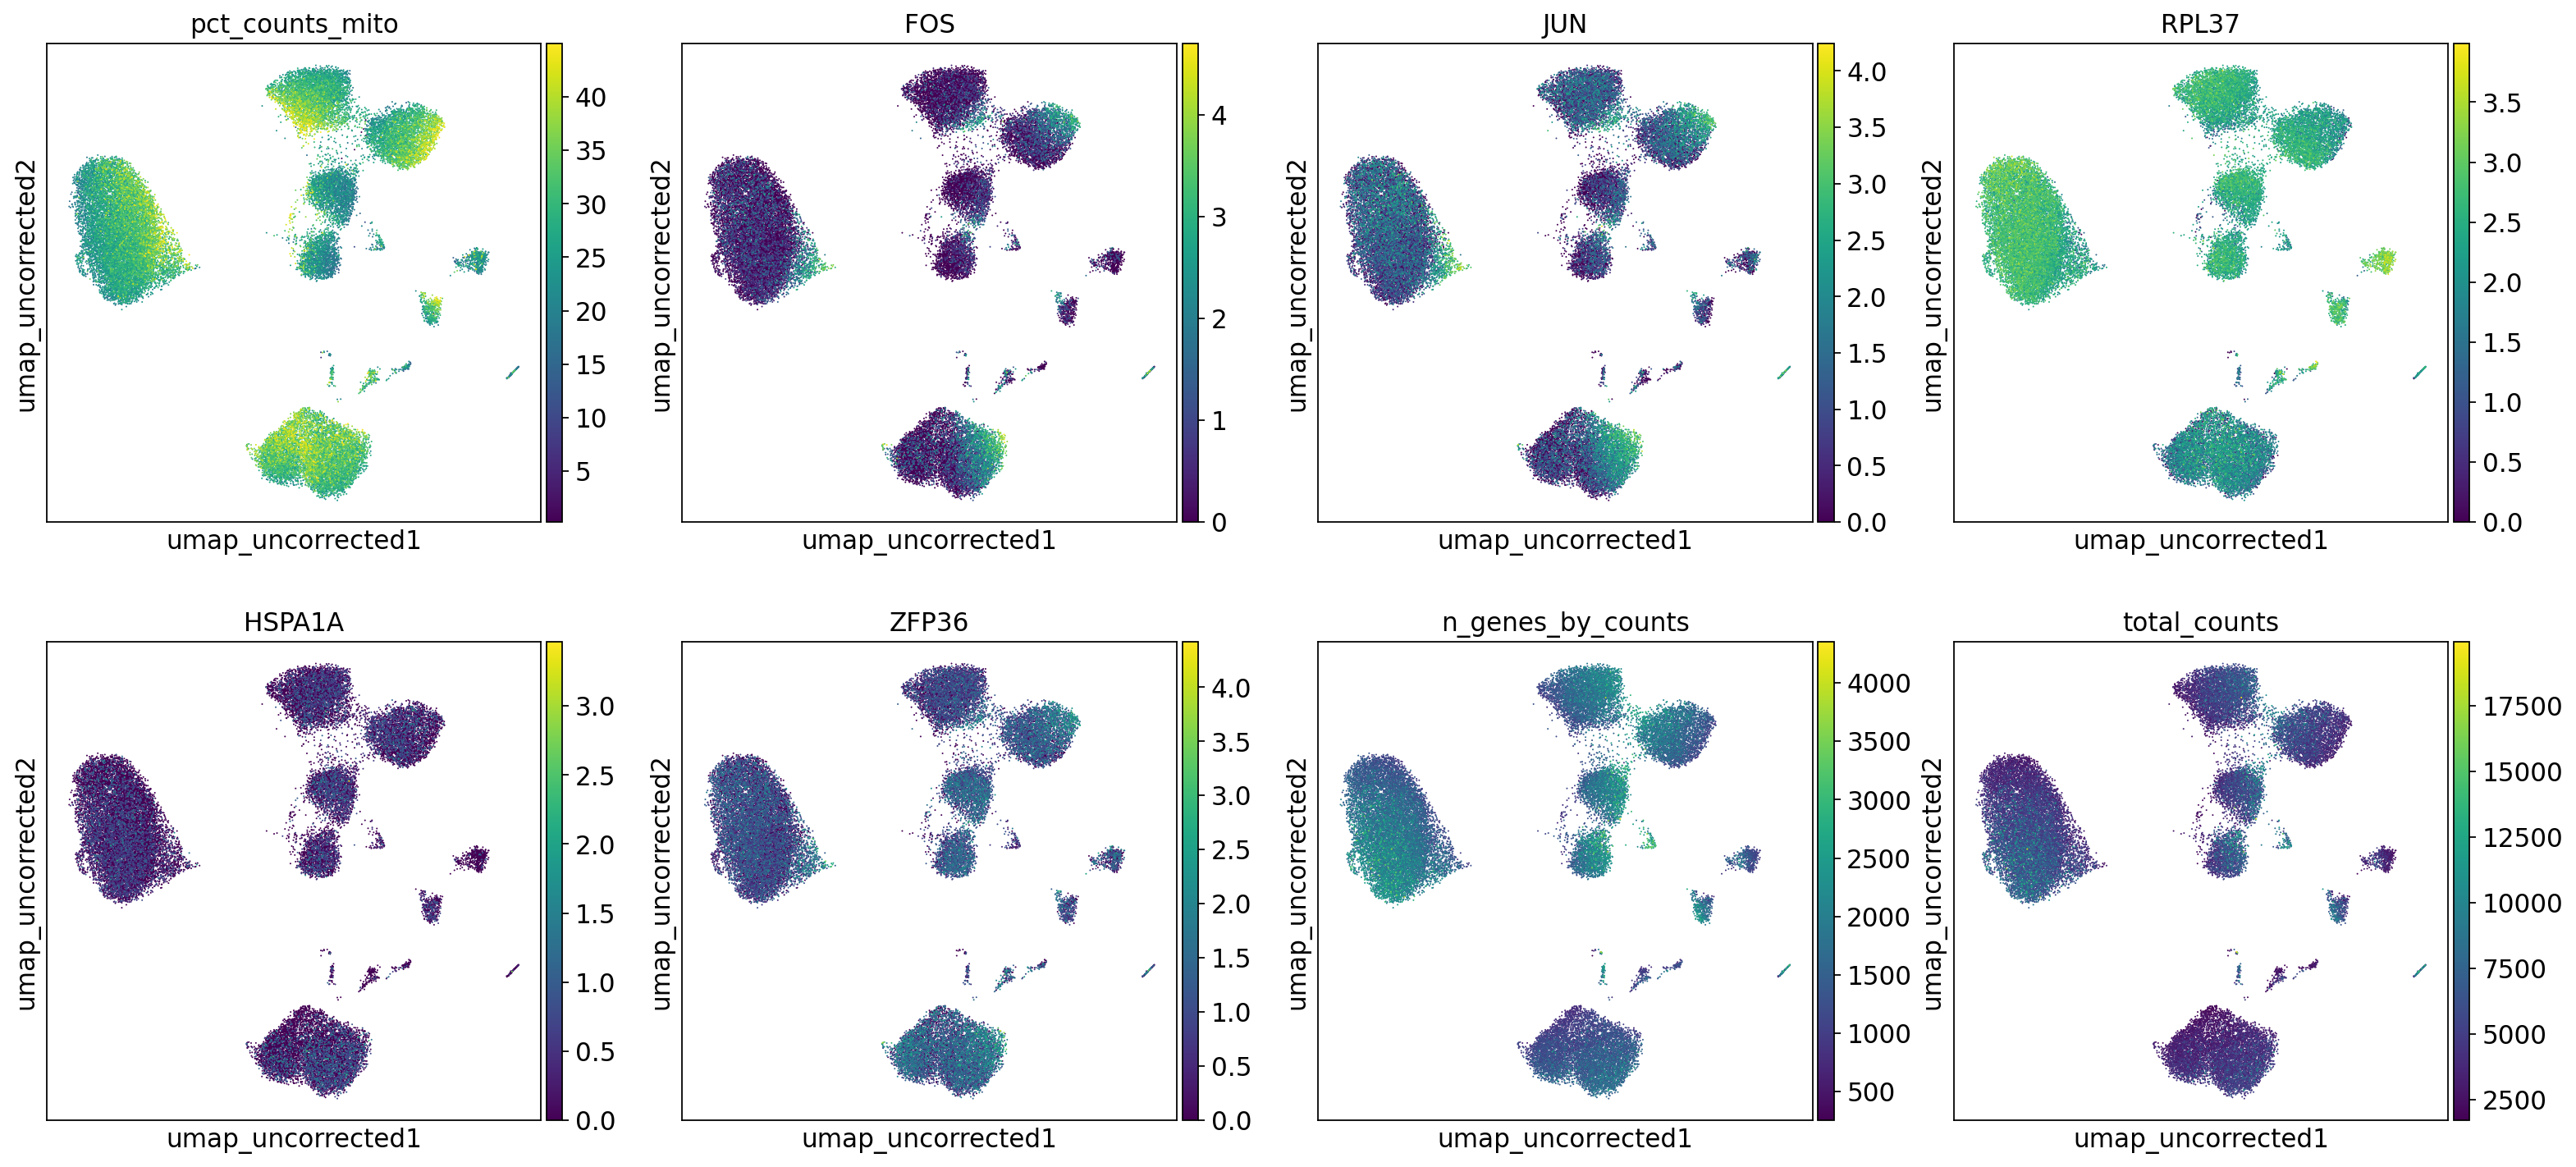

In [4]:
# plot fos/jun markers and covariates
sc.pl.embedding(
    adata,
    basis="umap_uncorrected",
    color=[
        "pct_counts_mito",
        "FOS",
        "JUN",
        "RPL37",
        "HSPA1A",
        "ZFP36",
        "n_genes_by_counts",
        "total_counts",
    ],
)

In [5]:
adata = adata[adata.obs["timepoint"] == "T0", :]

# Progeny

In [6]:
model = progeny.load_model(
    organism="Human",  # If working with mouse, set to Mouse
    top=1000,  # For sc we recommend ~1k target genes since there are dropouts
)

In [52]:
progeny.run(
    adata,
    model,
    center=True,  # Center gene expression by mean per cell
    num_perm=0,  # Simulate m random activities
    norm=True,  # Normalize by number of edges to correct for large regulons
    scale=True,  # Scale values per feature so that values can be compared across cells
)

7353 genes found


## IG loci

Only look at H cells!

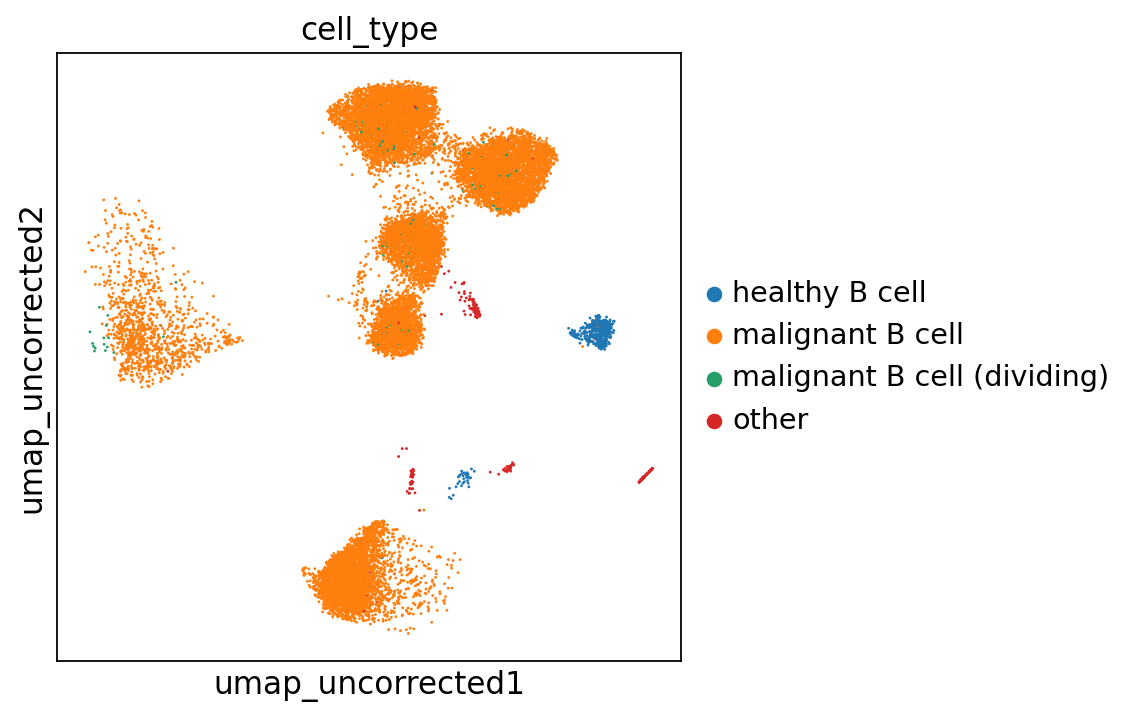

In [10]:
sc.pl.embedding(adata, "umap_uncorrected", color="cell_type")

In [11]:
adata_h = adata[adata.obs["cell_type"] == "malignant B cell", :]

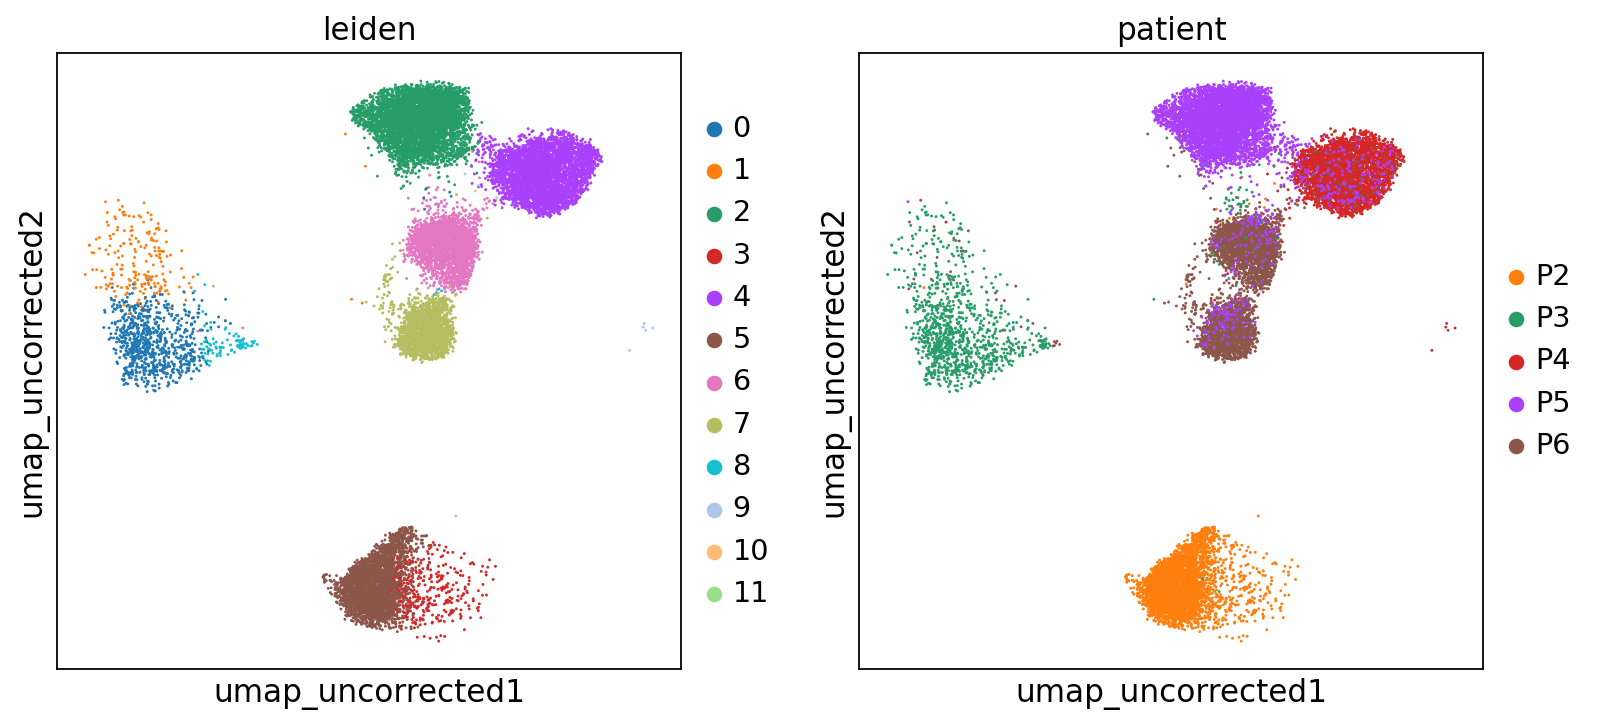

In [12]:
sc.pl.embedding(adata_h, basis="umap_uncorrected", color=["leiden", "patient"])

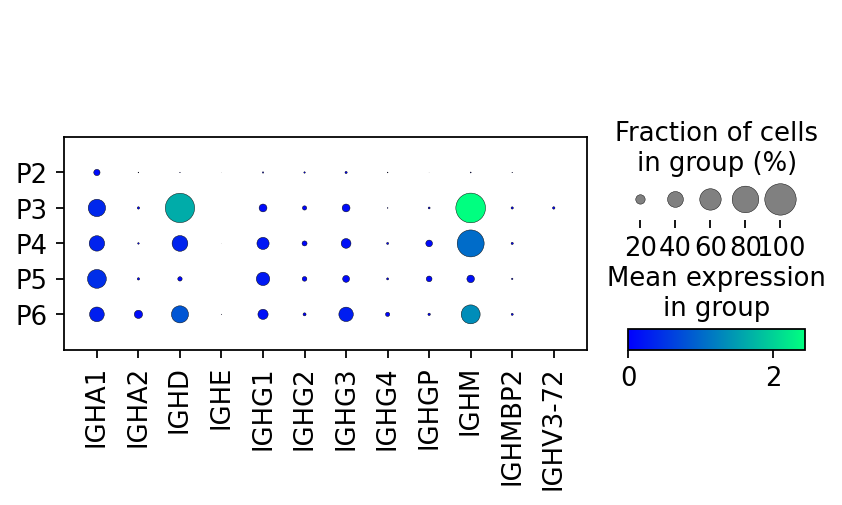

In [13]:
sc.pl.DotPlot(
    adata_h,
    groupby="patient",
    var_names=adata.var_names[adata.var_names.str.startswith("IGH")],
).show()

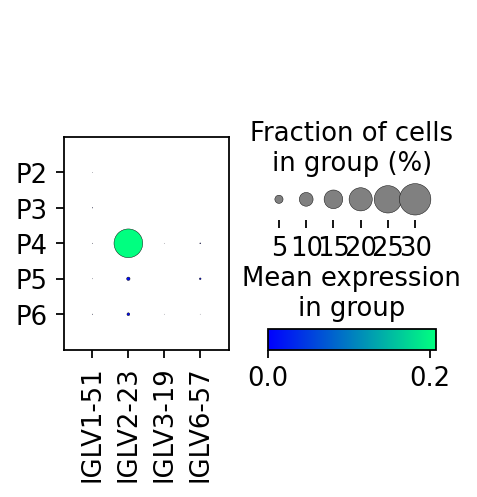

In [14]:
sc.pl.DotPlot(
    adata_h,
    groupby="patient",
    var_names=adata.var_names[adata.var_names.str.startswith("IGLV")],
).show()

### P6 diff between clones

In [15]:
adata_p6 = adata_h[adata_h.obs["patient"] == "P6"]
adata_p6.obs["clone"] = [
    {"6": "clone 1", "7": "clone 2"}.get(x, None) for x in adata_p6.obs["leiden"]
]

Trying to set attribute `.obs` of view, copying.


/data/scratch/sturm/conda/envs/2021-hairy-cell-leukemia-wolf-scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'clone' as categorical


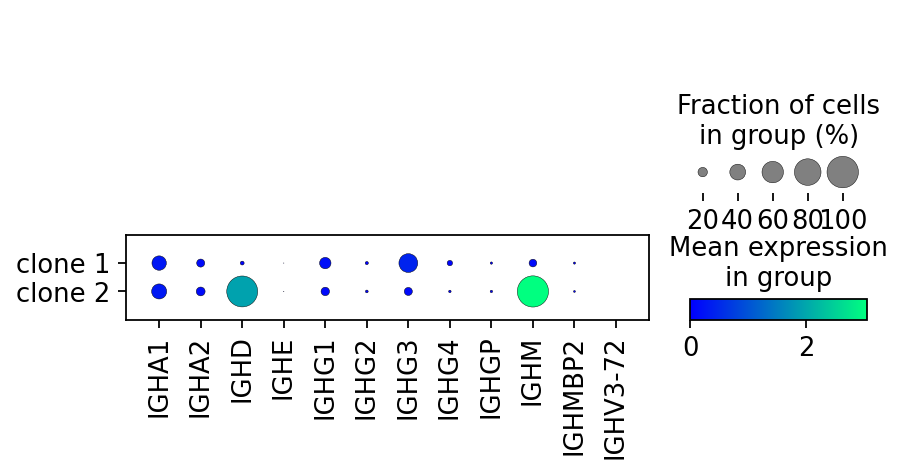

In [16]:
sc.pl.DotPlot(
    adata_p6,
    groupby="clone",
    var_names=adata.var_names[adata.var_names.str.startswith("IGH")],
).show()

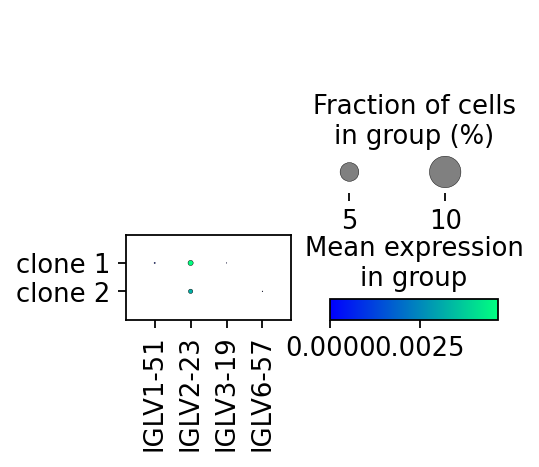

In [17]:
sc.pl.DotPlot(
    adata_p6,
    groupby="clone",
    var_names=adata.var_names[adata.var_names.str.startswith("IGLV")],
).show()

In [18]:
adata.obs["p6_clone"] = adata_p6.obs["clone"]

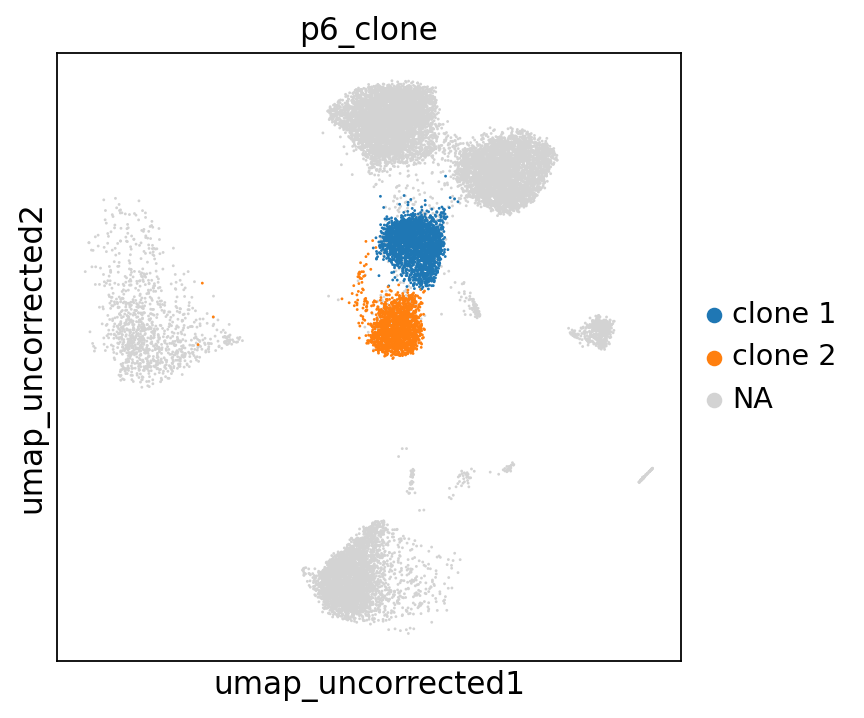

In [19]:
sc.pl.embedding(adata, basis="umap_uncorrected", color="p6_clone")

### CD27 expression
CD27 sould only be expressed on H cells

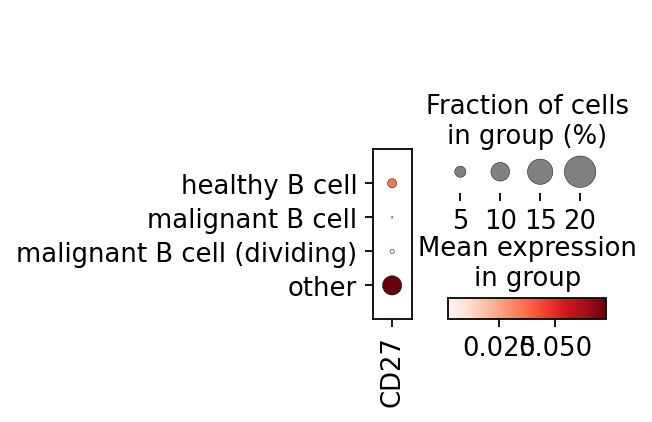

In [20]:
sc.pl.dotplot(adata, var_names=["CD27"], groupby="cell_type")

CD27 expression on healthy B cells, by patient

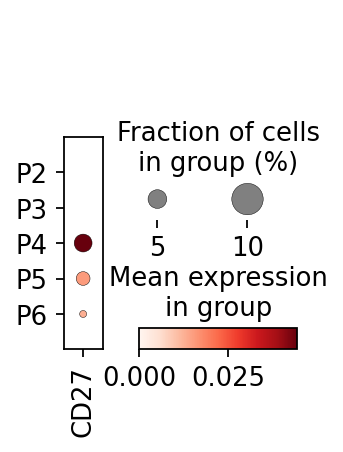

In [21]:
sc.pl.dotplot(
    adata[adata.obs["cell_type"] == "healthy B cell", :],
    var_names=["CD27"],
    groupby="patient",
)

### Marker dotplot from B-cell atlas

In [22]:
b_cell_atlas_genes = [
    "HOPX",
    "PDE4D",
    "IGHE",
    "SELL",
    "EMP3",
    "CIB1",
    "PSAP",
    "CD72",
    "DAPP1",
    "LTB",
    "HCK",
    "ZEB2",
    "RHOB",
    "TNFRSF1B",
    "FCRL3",
    "FCRL5",
    "FGR",
    "MPP6",
    "TAGLN2",
    "IGHA2",
    "AHNAK",
    "S100A4",
    "CRIP2",
    "ITGB1",
    "JCHAIN",
    "VIM",
    "PLPP5",
    "FCER2",
    "IL4R",
    "CRIP1",
    "LGALS1",
    "CTSH",
    "S100A10",
    "IGHG2",
    "VPREB3",
    "PPP1R14A",
    "PCDH9",
    "PLD4",
    "IGHM",
    "MT-ATP8",
    "IGHD",
    "SOX4",
    "AL139020.1",
    "IGLL5",
    "TCL1A",
]

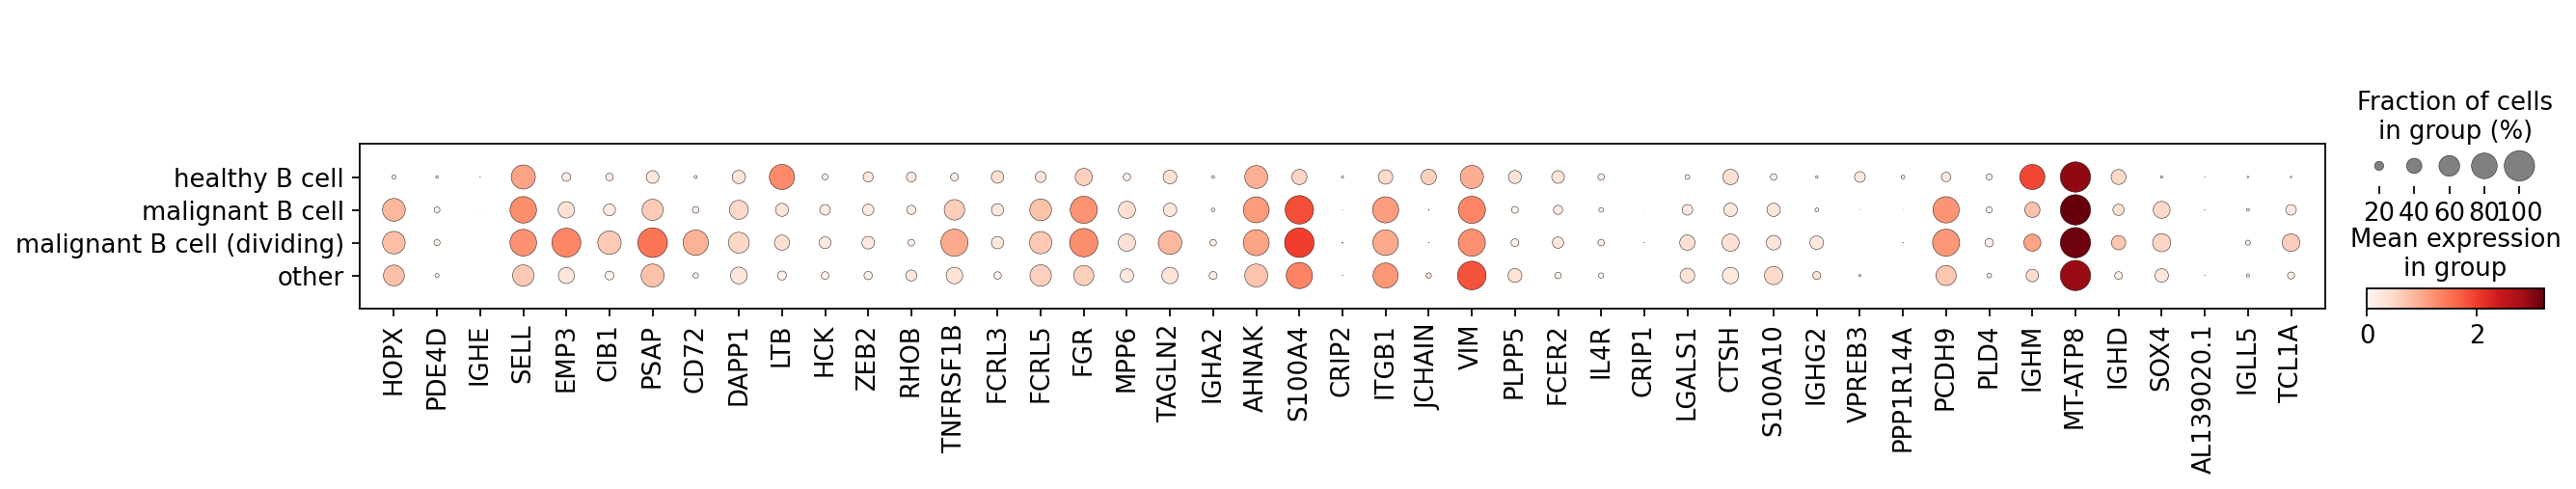

In [23]:
sc.pl.dotplot(
    adata,
    var_names=b_cell_atlas_genes,
    swap_axes=False,
    groupby="cell_type",
)

## Gene heatmap

In [24]:
tmp_adata = adata.copy()
tmp_adata.obs["patient_cell_type"] = [
    f"malignant B {p}" if ct == "malignant B cell" else ct
    for p, ct in zip(adata.obs["patient"], adata.obs["cell_type"])
]

/data/scratch/sturm/conda/envs/2021-hairy-cell-leukemia-wolf-scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'patient_cell_type' as categorical


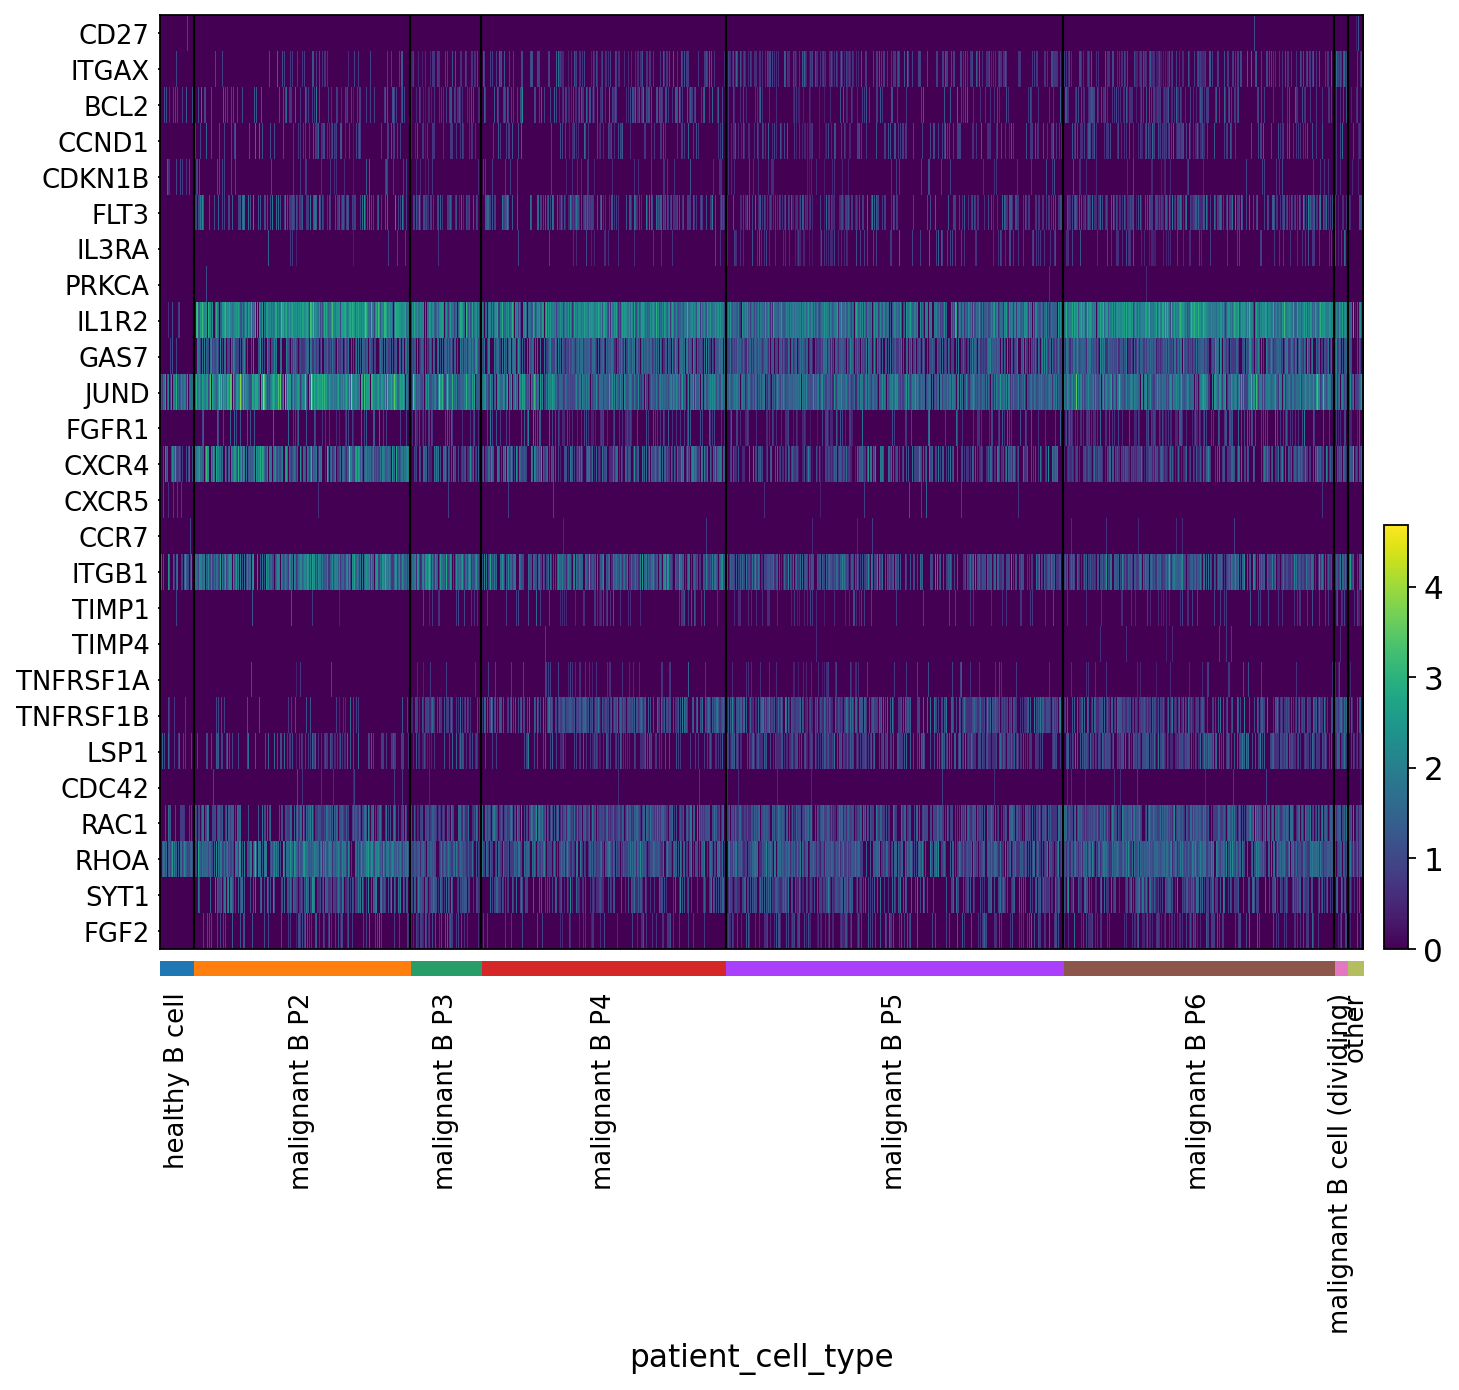

In [25]:
sc.pl.heatmap(
    tmp_adata,
    var_names="""CD27
ITGAX
BCL2
CCND1
CDKN1B
FLT3
IL3RA
PRKCA
IL1R2
GAS7
JUND
FGFR1
CXCR4
CXCR5
CCR7
ITGB1
TIMP1
TIMP4
TNFRSF1A
TNFRSF1B
LSP1
CDC42
RAC1
RHOA
SYT1
FGF2
""".split(),
    groupby="patient_cell_type",
    swap_axes=True,
    figsize=(10, 8),
)

### Heatmap DE malignant vs. healthy

In [26]:
def read_gmt(file):
    signatures = {}
    with open(file) as f:
        for line in f.readlines():
            cols = line.strip().split("\t")
            name = cols[0]
            genes = cols[2:]
            signatures[name] = genes
    return signatures

In [27]:
kegg_pathways = read_gmt("../../tables/c2.cp.kegg.v7.4.symbols.gmt")

In [28]:
de_res = pd.read_csv(
    "../../data/70_de_analysis/72_run_de/deseq2_res_sc_healthy_vs_malignant_b_cells/malignant_healthy_IHWallGenes.tsv",
    sep="\t",
)

FileNotFoundError: [Errno 2] No such file or directory: '../../data/70_de_analysis/72_run_de/deseq2_res_sc_healthy_vs_malignant_b_cells/malignant_healthy_IHWallGenes.tsv'

In [ ]:
var_names = (
    de_res.loc[de_res["log2FoldChange"] > 0, :]
    .sort_values("padj")["gene_id"][:30]
    .values
)

In [ ]:
signatures = {var: [] for var in var_names}
for var in var_names:
    for sig, genes in kegg_pathways.items():
        if var in genes:
            signatures[var].append(sig)

In [ ]:
import itertools

In [ ]:
pd.DataFrame.from_records(
    itertools.chain.from_iterable(
        zip(itertools.repeat(gene), pws) for gene, pws in signatures.items()
    )
).to_csv("/home/sturm/Downloads/gene_to_kegg.csv")

In [ ]:
signatures

In [ ]:
sc.pl.heatmap(
    tmp_adata,
    var_names=,
    groupby="patient_cell_type",
    swap_axes=True,
    figsize=(10, 8),
)

## Compare pathway scores by cell-type

 * statistical unit = "cell"
 * all cell-types
 * "T0" only

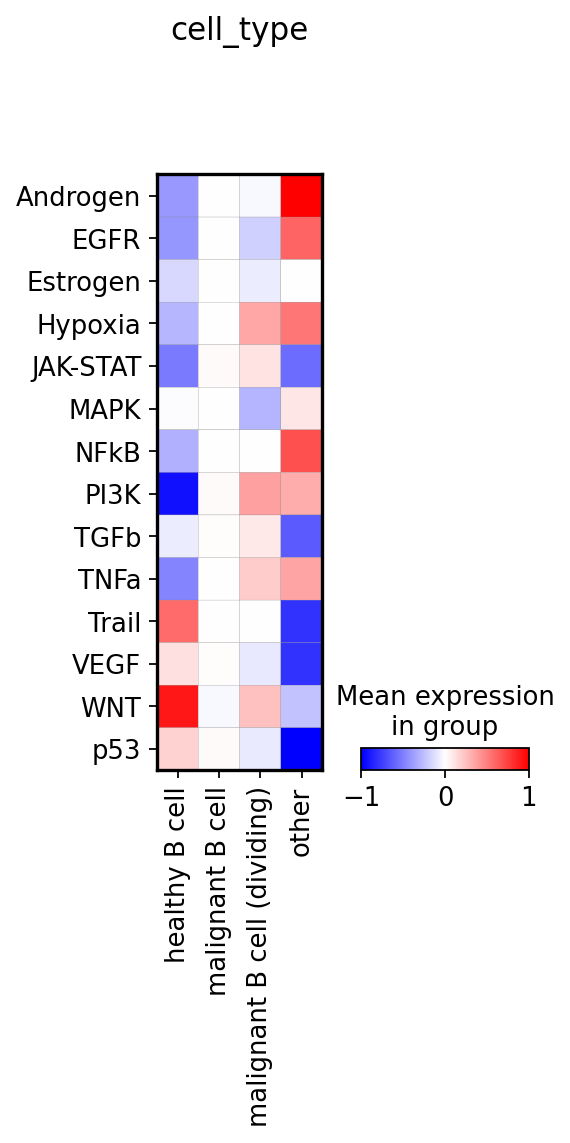

In [29]:
sc.pl.matrixplot(
    adata_pw,
    var_names=adata.obsm["progeny"].columns,
    groupby="cell_type",
    swap_axes=True,
    cmap="bwr",
    title="cell_type",
    vmin=-1,
    vmax=1,
)

### healthy and malignant B cells by patient
 * excluding P3 since it only has 3 healthy B cells

In [30]:
adata_pw.obs.loc[
    adata_pw.obs["cell_type"].isin(["healthy B cell", "malignant B cell"]), :
].groupby(["patient", "cell_type"], observed=True).size().reset_index()

patient         cell_type     0
0      P2  malignant B cell  3350
1      P2    healthy B cell    34
2      P4  malignant B cell  3782
3      P4    healthy B cell   382
4      P6  malignant B cell  4186
5      P6    healthy B cell    74
6      P3  malignant B cell  1093
7      P3    healthy B cell     3
8      P5  malignant B cell  5211
9      P5    healthy B cell    30

In [31]:
adata_pw_ct_patient = adata_pw[
    adata_pw.obs["cell_type"].isin(["healthy B cell", "malignant B cell"])
    & (adata.obs["patient"] != "P3"),
    :,
]
adata_pw_ct_patient.obs["ct_patient"] = [
    f"{p} {ct}"
    for p, ct in zip(
        adata_pw_ct_patient.obs["patient"], adata_pw_ct_patient.obs["cell_type"]
    )
]

Trying to set attribute `.obs` of view, copying.


/data/scratch/sturm/conda/envs/2021-hairy-cell-leukemia-wolf-scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'ct_patient' as categorical


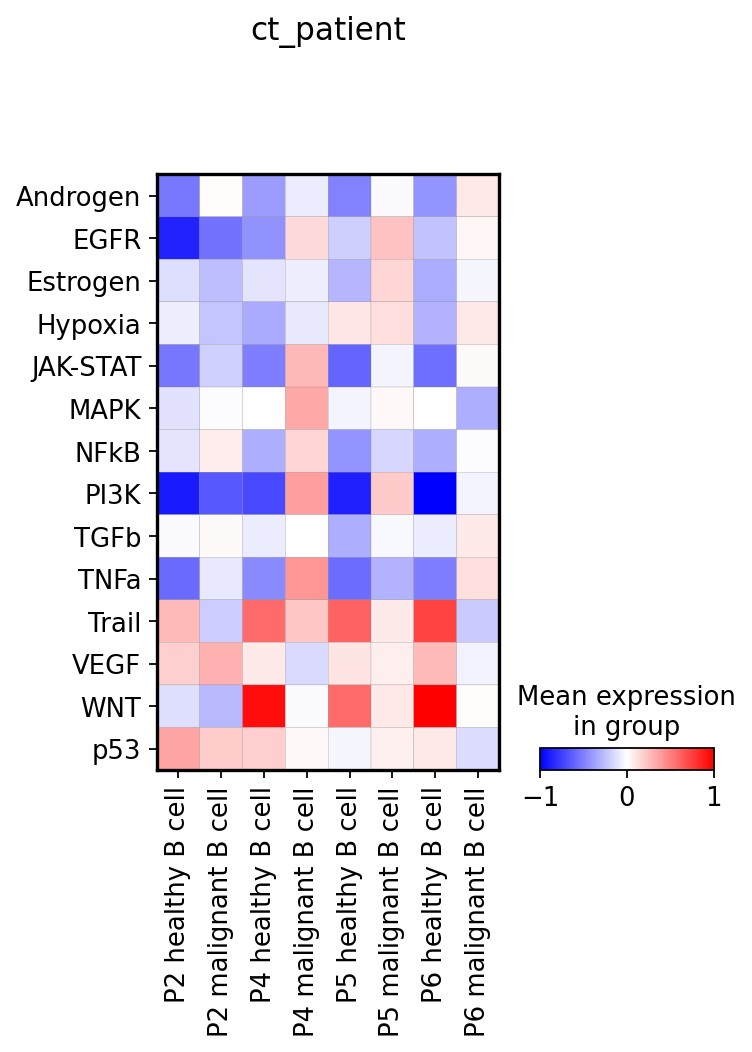

In [32]:
sc.pl.matrixplot(
    adata_pw_ct_patient,
    var_names=adata.obsm["progeny"].columns,
    groupby="ct_patient",
    swap_axes=True,
    cmap="bwr",
    title="ct_patient",
    vmin=-1,
    vmax=1,
)

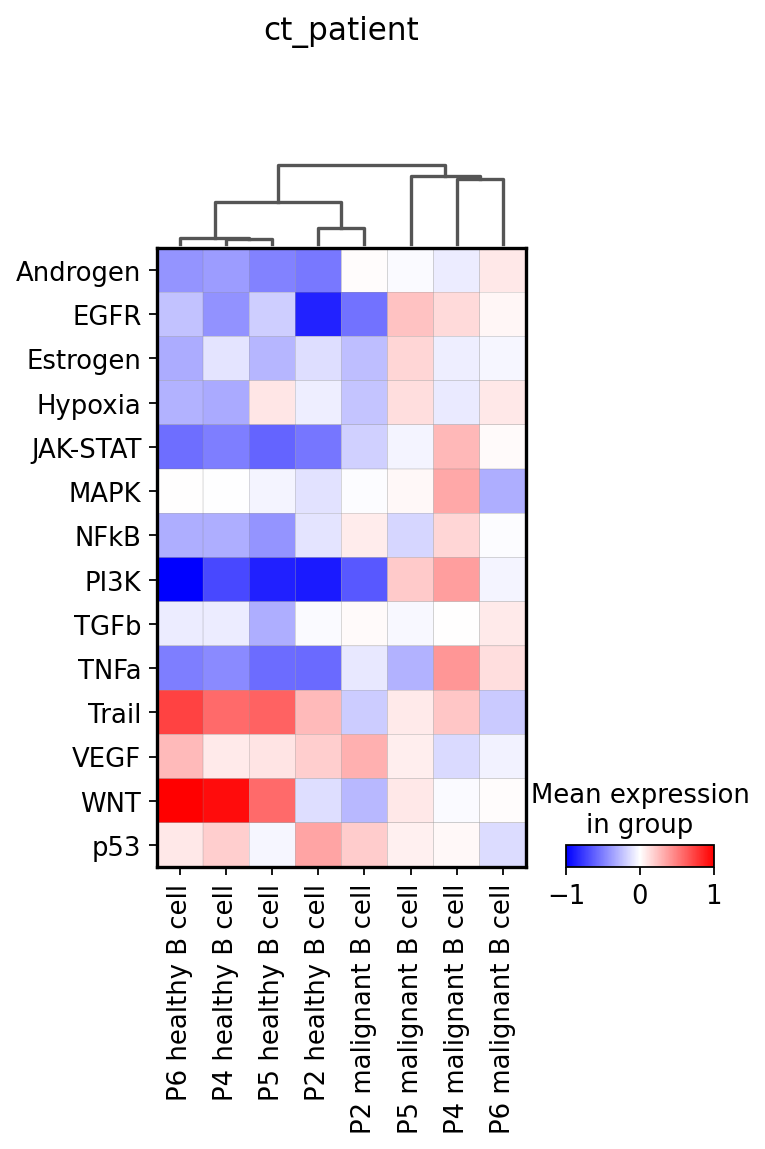

In [33]:
sc.pl.matrixplot(
    adata_pw_ct_patient,
    var_names=adata.obsm["progeny"].columns,
    groupby="ct_patient",
    swap_axes=True,
    cmap="bwr",
    title="ct_patient",
    vmin=-1,
    vmax=1,
    dendrogram=True,
)

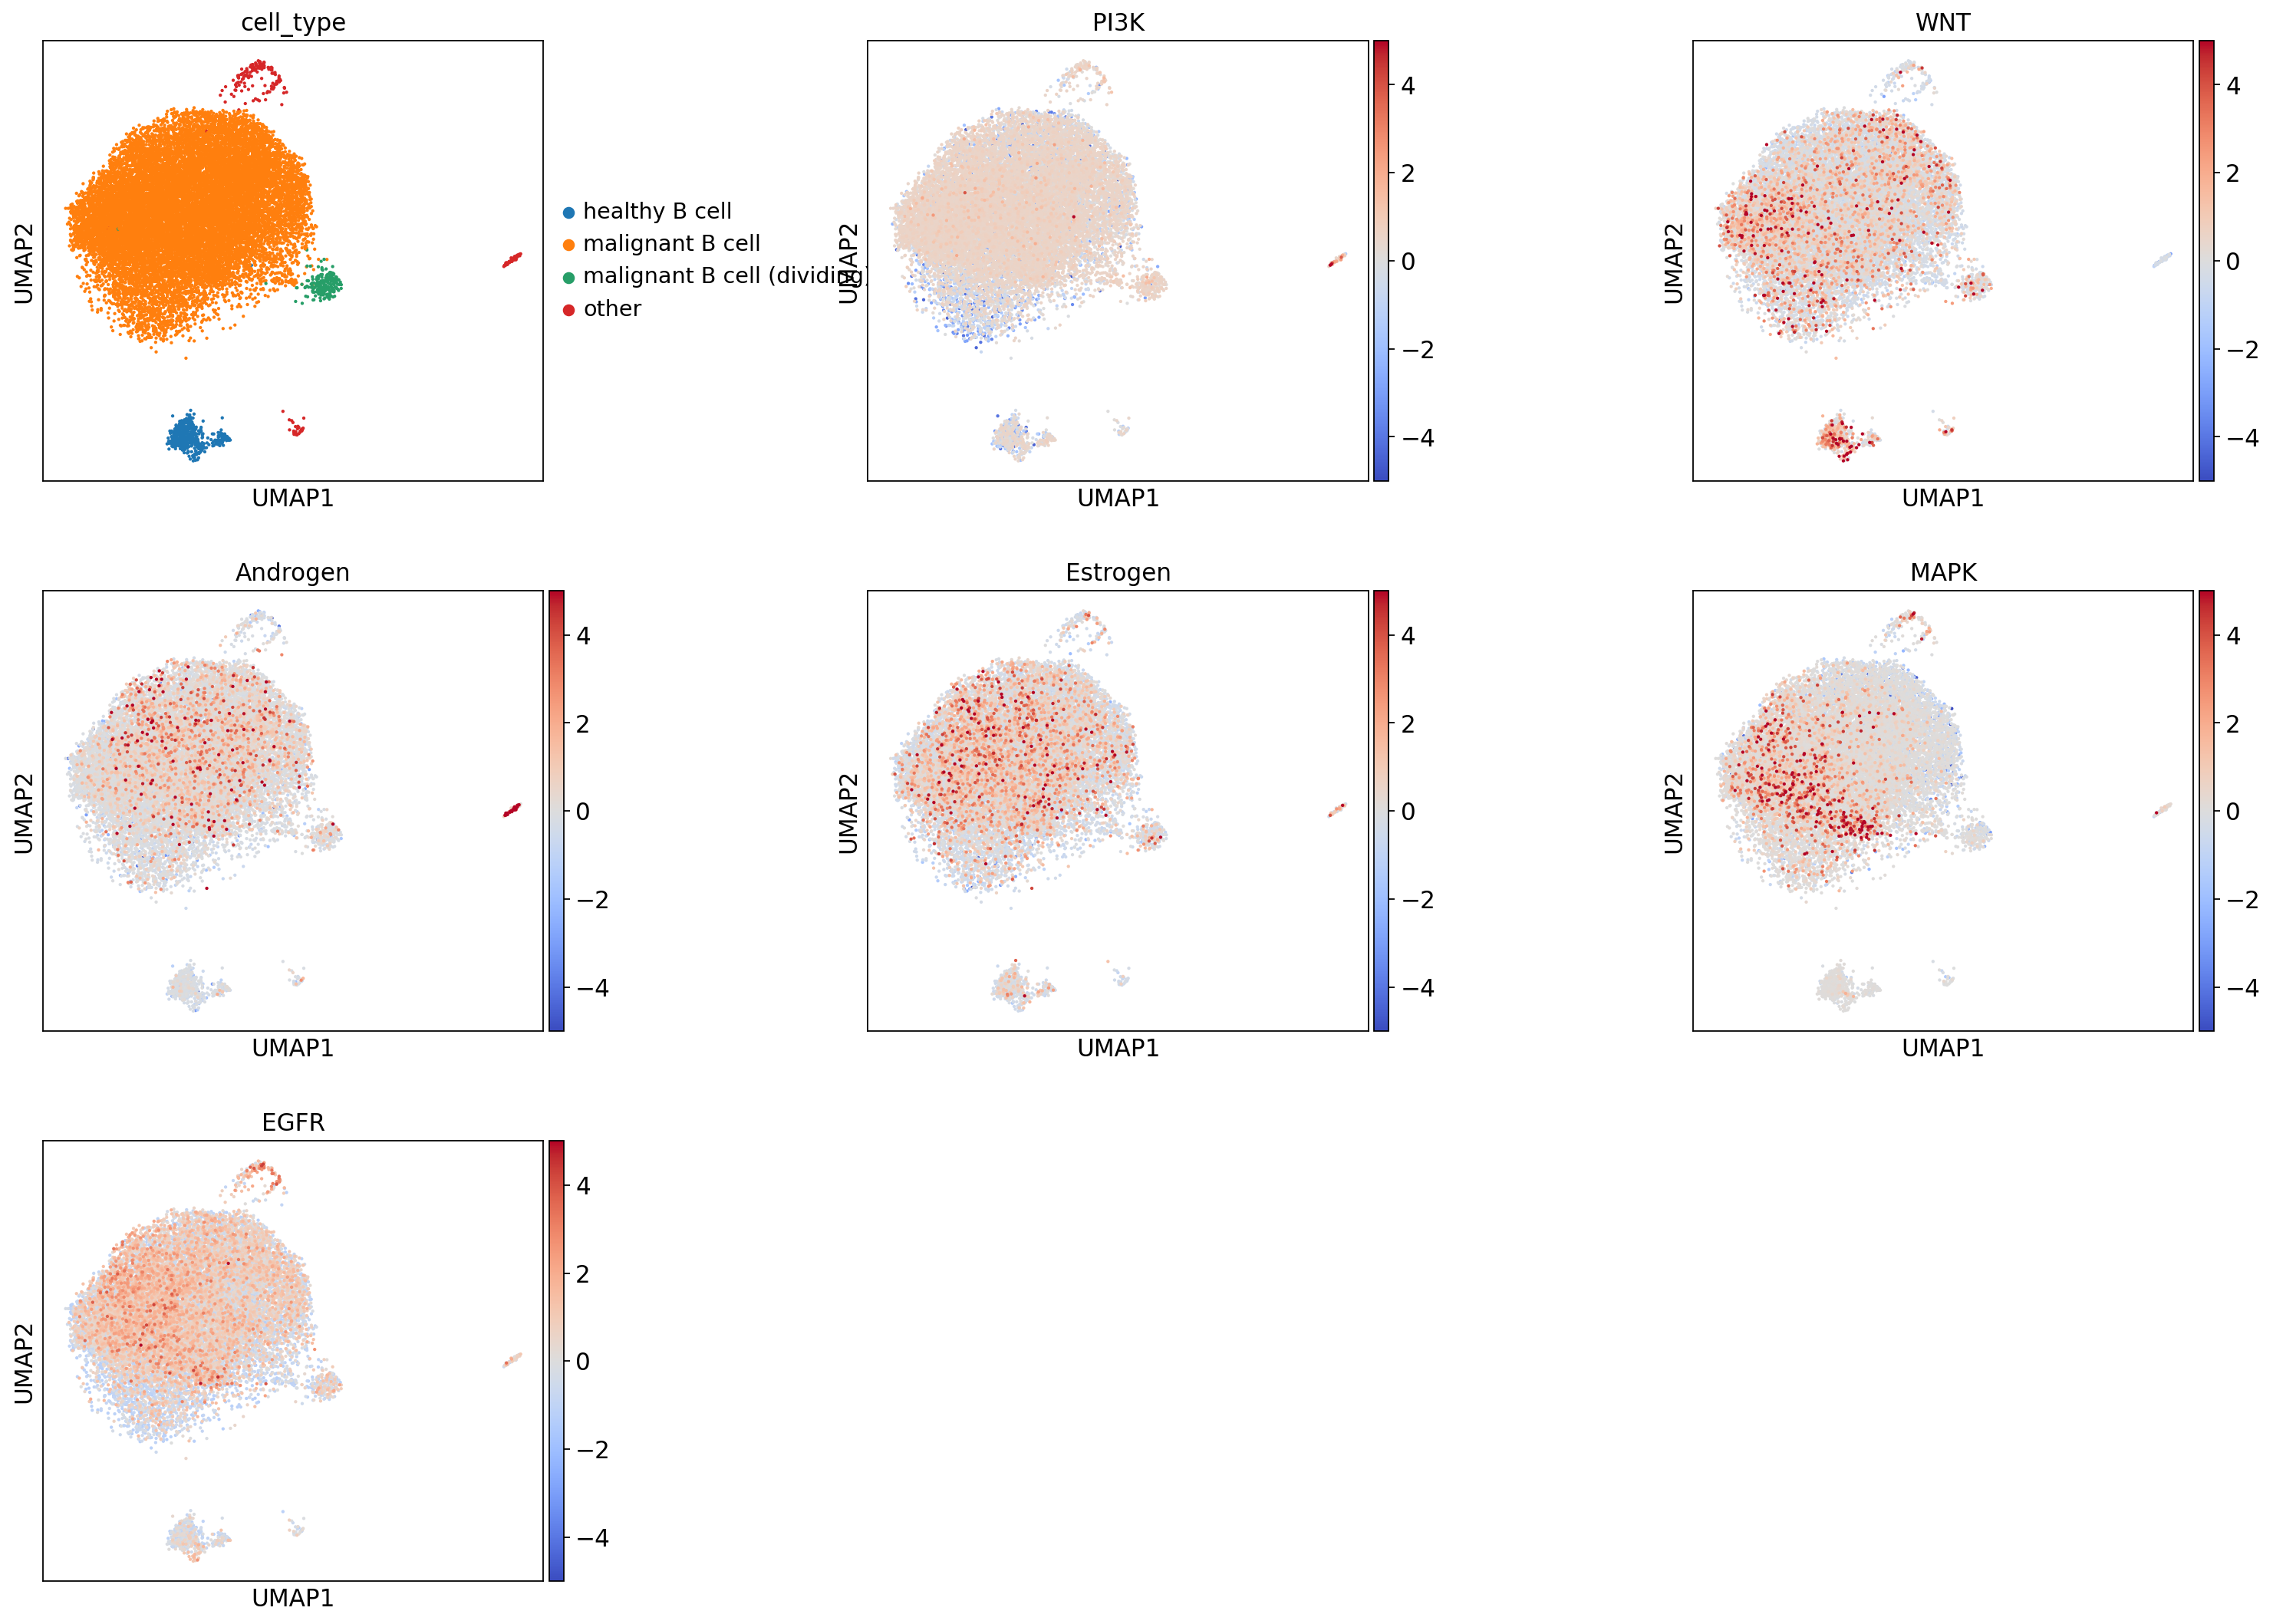

In [34]:
sc.pl.umap(
    adata_pw,
    color=["cell_type", "PI3K", "WNT", "Androgen", "Estrogen", "MAPK", "EGFR"],
    cmap="coolwarm",
    size=15,
    ncols=3,
    wspace=0.5,
    vmin=-5,
    vmax=5,
)

### statistical tests for pathway differences between cell-types

In [35]:
progeny_df = adata.obsm["progeny"].join(adata.obs.loc[:, ["cell_type", "patient"]])
progeny_by_sample = (
    progeny_df.groupby(["cell_type", "patient"], observed=True)
    .agg("mean")
    .reset_index()
    .sort_values("patient")
)

In [36]:
progeny_by_sample_melt = progeny_by_sample.loc[
    progeny_by_sample["cell_type"].isin(["healthy B cell", "malignant B cell"]), :
].melt(
    id_vars=["cell_type", "patient"],
    var_name="pathway",
    value_name="progeny_score",
)
progeny_by_sample_melt["cell_type"] = pd.Categorical(
    progeny_by_sample_melt["cell_type"],
    categories=["healthy B cell", "malignant B cell"],
)

In [37]:
df_for_test = progeny_by_sample.drop("patient", axis="columns").set_index("cell_type")

In [38]:
_, pvals = scipy.stats.ttest_rel(
    df_for_test.loc["healthy B cell", :], df_for_test.loc["malignant B cell", :], axis=0
)
pval_dict = {k: v for k, v in zip(df_for_test.columns, pvals)}

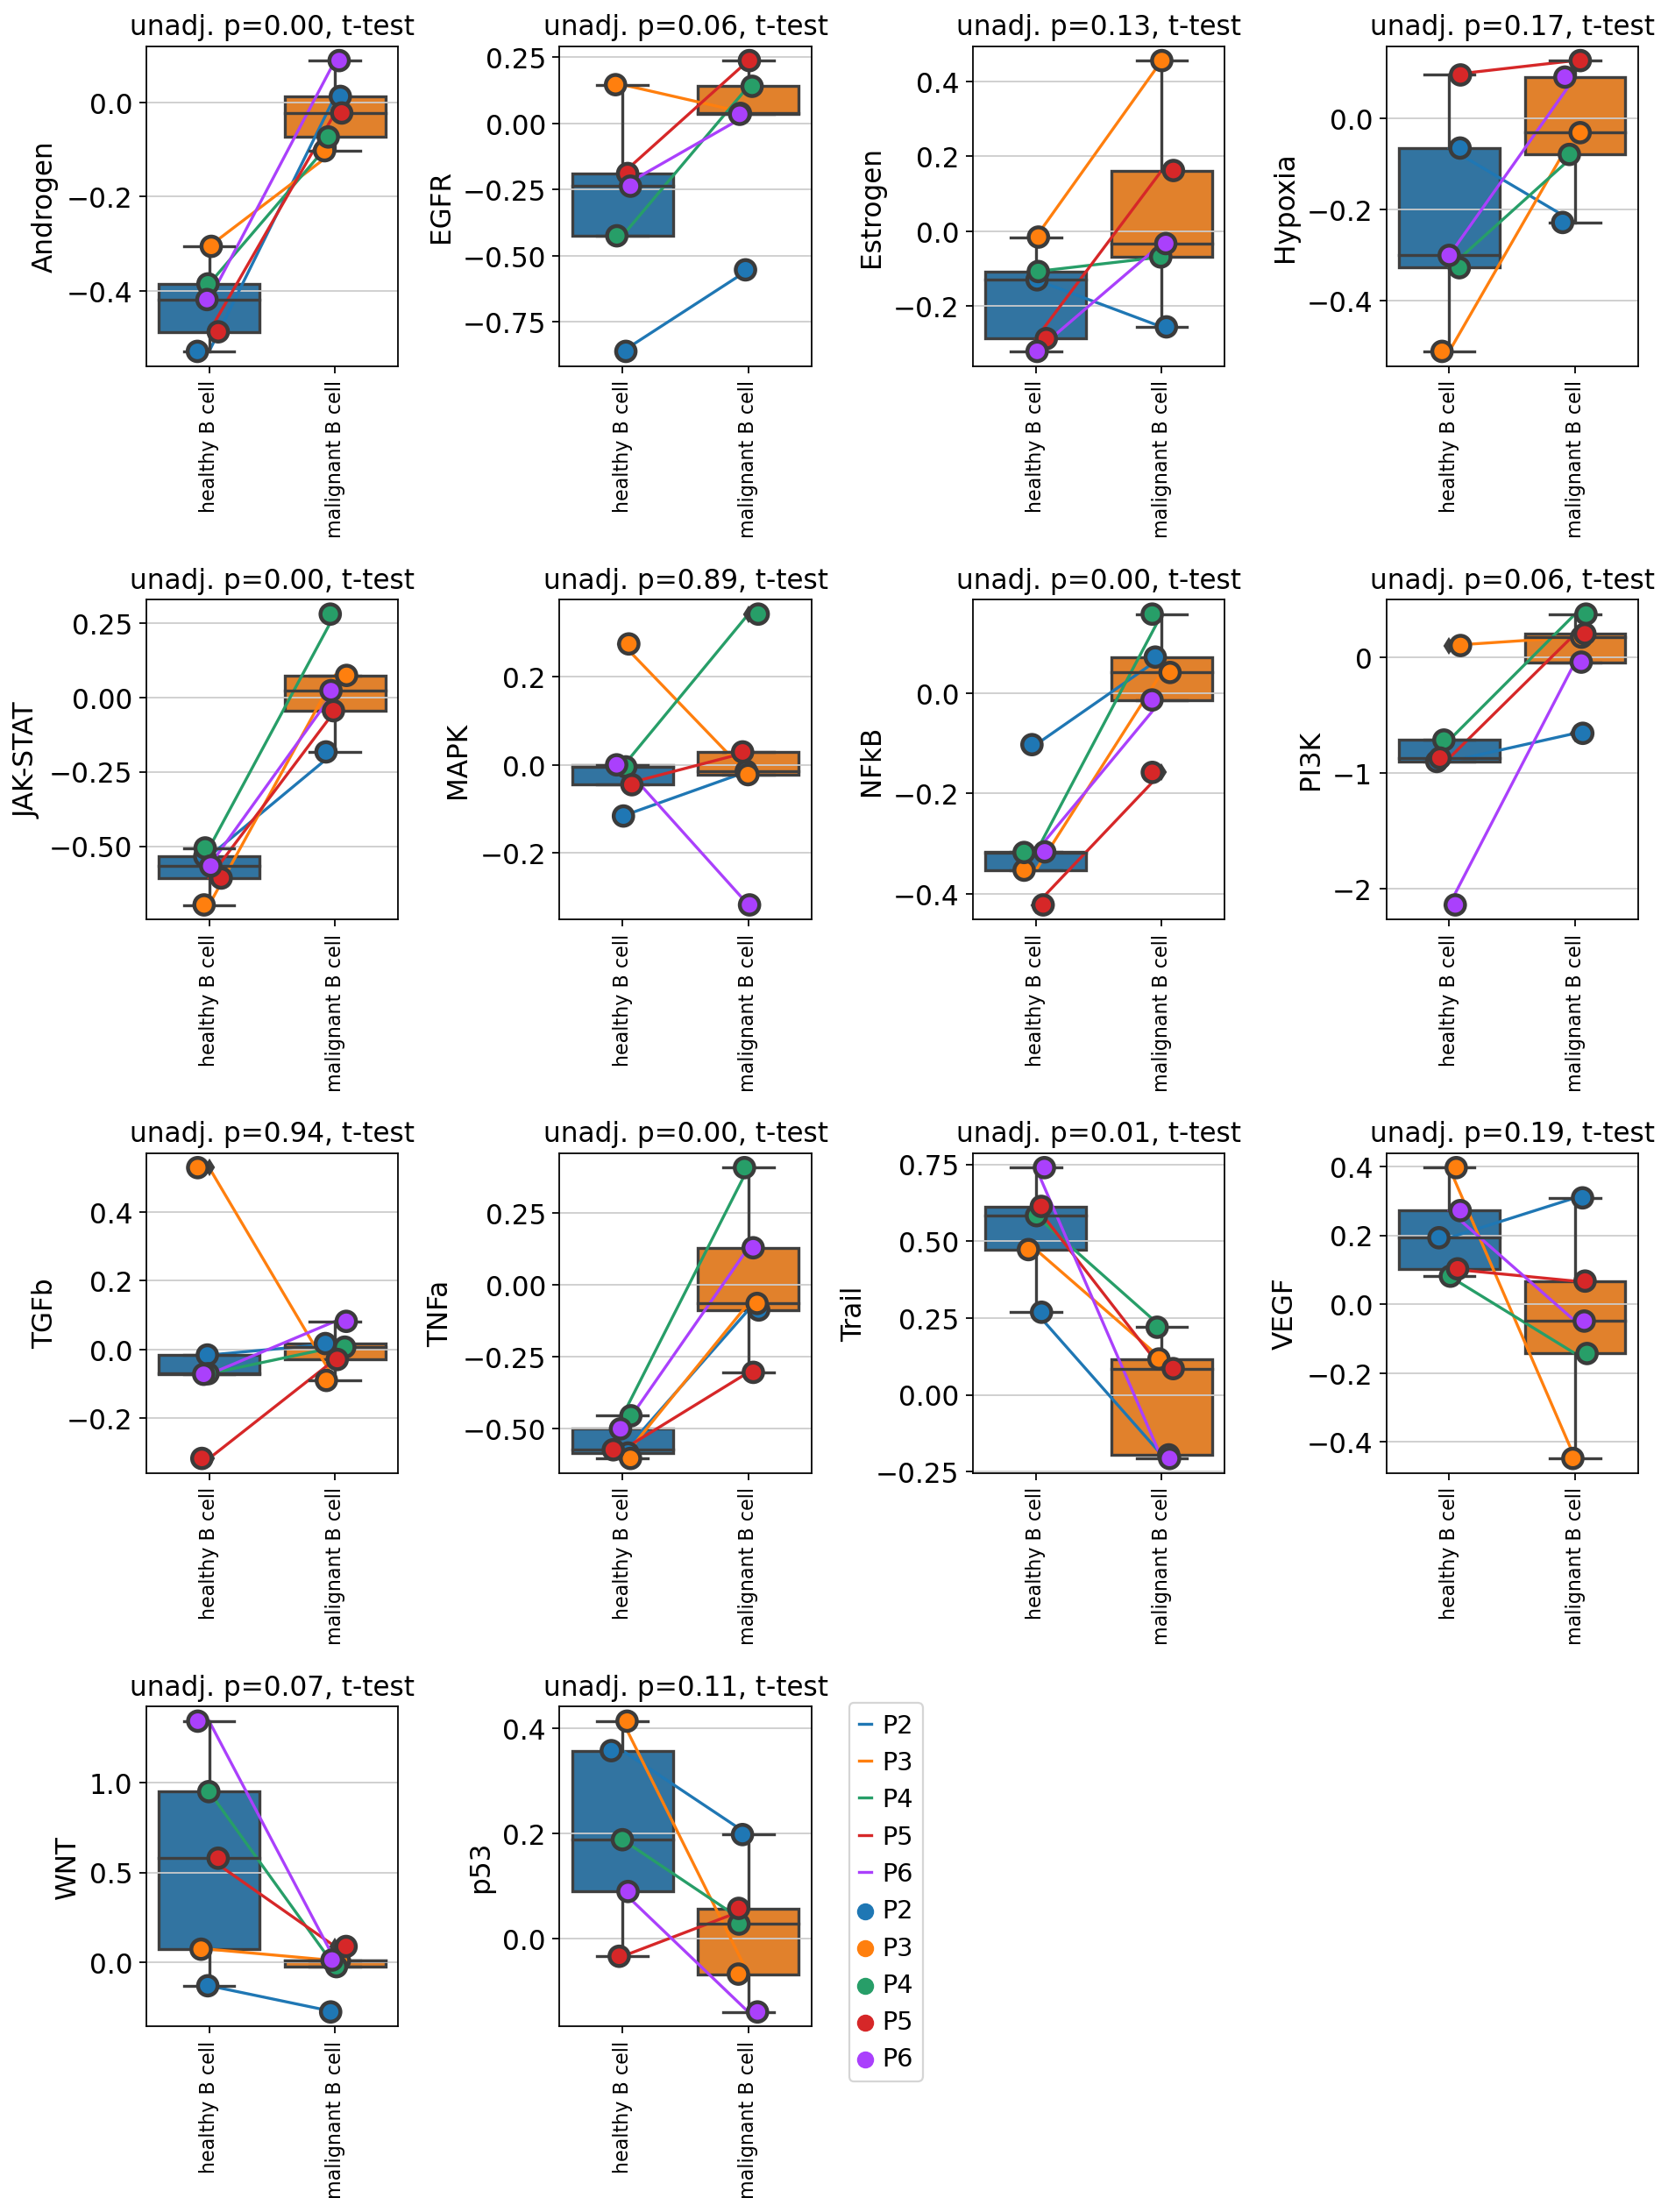

In [39]:
fig, axes = plt.subplots(4, 4, figsize=(4 * 3, 4 * 4), tight_layout=True)
axes = axes.flatten()
for pw, ax in zip(adata_pw.var.index, axes):
    sns.stripplot(
        x="cell_type",
        data=progeny_by_sample_melt.query(f"pathway == '{pw}'"),
        y="progeny_score",
        ax=ax,
        hue="patient",
        size=10,
        linewidth=2,
    )
    sns.lineplot(
        x="cell_type",
        data=progeny_by_sample_melt.query(f"pathway == '{pw}'"),
        hue="patient",
        y="progeny_score",
        ax=ax,
    )
    sns.boxplot(
        x="cell_type",
        data=progeny_by_sample_melt.query(f"pathway == '{pw}'"),
        y="progeny_score",
        ax=ax,
    )

    ax.set_xlabel("")
    ax.tick_params(axis="x", rotation=90, labelsize=10)
    ax.legend().set_visible(False)
    ax.set_ylabel(pw)
    ax.set_title("unadj. p={:.2f}, t-test".format(pval_dict[pw]))
axes[-1].set_visible(False)
axes[-2].set_visible(False)
axes[-3].legend().set_visible(True)
axes[-3].legend(bbox_to_anchor=(1.1, 1.05))
fig.tight_layout()
plt.show()

In [40]:
# pw_test_cell_type = rank_pw_groups_all(adata_pw, "cell_type").sort_values("pval")
# pw_test_cell_type

## Pathway differences between short-term and long-term responders
 * statistical unit = "patient"
 * use "malignant B cells" only
 * use "T0" only

In [41]:
adata = adata[adata.obs["cell_type"] == "malignant B cell", :]

In [42]:
progeny.run(
    adata,
    model,
    center=True,  # Center gene expression by mean per cell
    num_perm=100,  # Simulate m random activities
    norm=True,  # Normalize by number of edges to correct for large regulons
    scale=True,  # Scale values per feature so that values can be compared across cells
)

7353 genes found


100%|██████████| 100/100 [01:56<00:00,  1.17s/it]


In [43]:
adata_pw = progeny.extract(adata)

In [44]:
progeny_df = adata.obsm["progeny"].join(adata.obs.loc[:, ["patient", "response"]])

In [45]:
progeny_by_patient = (
    progeny_df.groupby(["patient", "response"], observed=True)
    .agg("mean")
    .reset_index()
    .sort_values("patient")
)

In [46]:
progeny_by_patient_melt = progeny_by_patient.melt(
    id_vars=["patient", "response"], var_name="pathway", value_name="progeny_score"
)
progeny_by_patient_melt["response"] = pd.Categorical(
    progeny_by_patient_melt["response"], categories=["short_term", "long_term"]
)

In [47]:
df_for_test = progeny_by_patient.drop("patient", axis="columns").set_index("response")

In [48]:
_, pvals = scipy.stats.ttest_ind(
    df_for_test.loc["short_term", :], df_for_test.loc["long_term", :], axis=0
)
pval_dict = {k: v for k, v in zip(df_for_test.columns, pvals)}

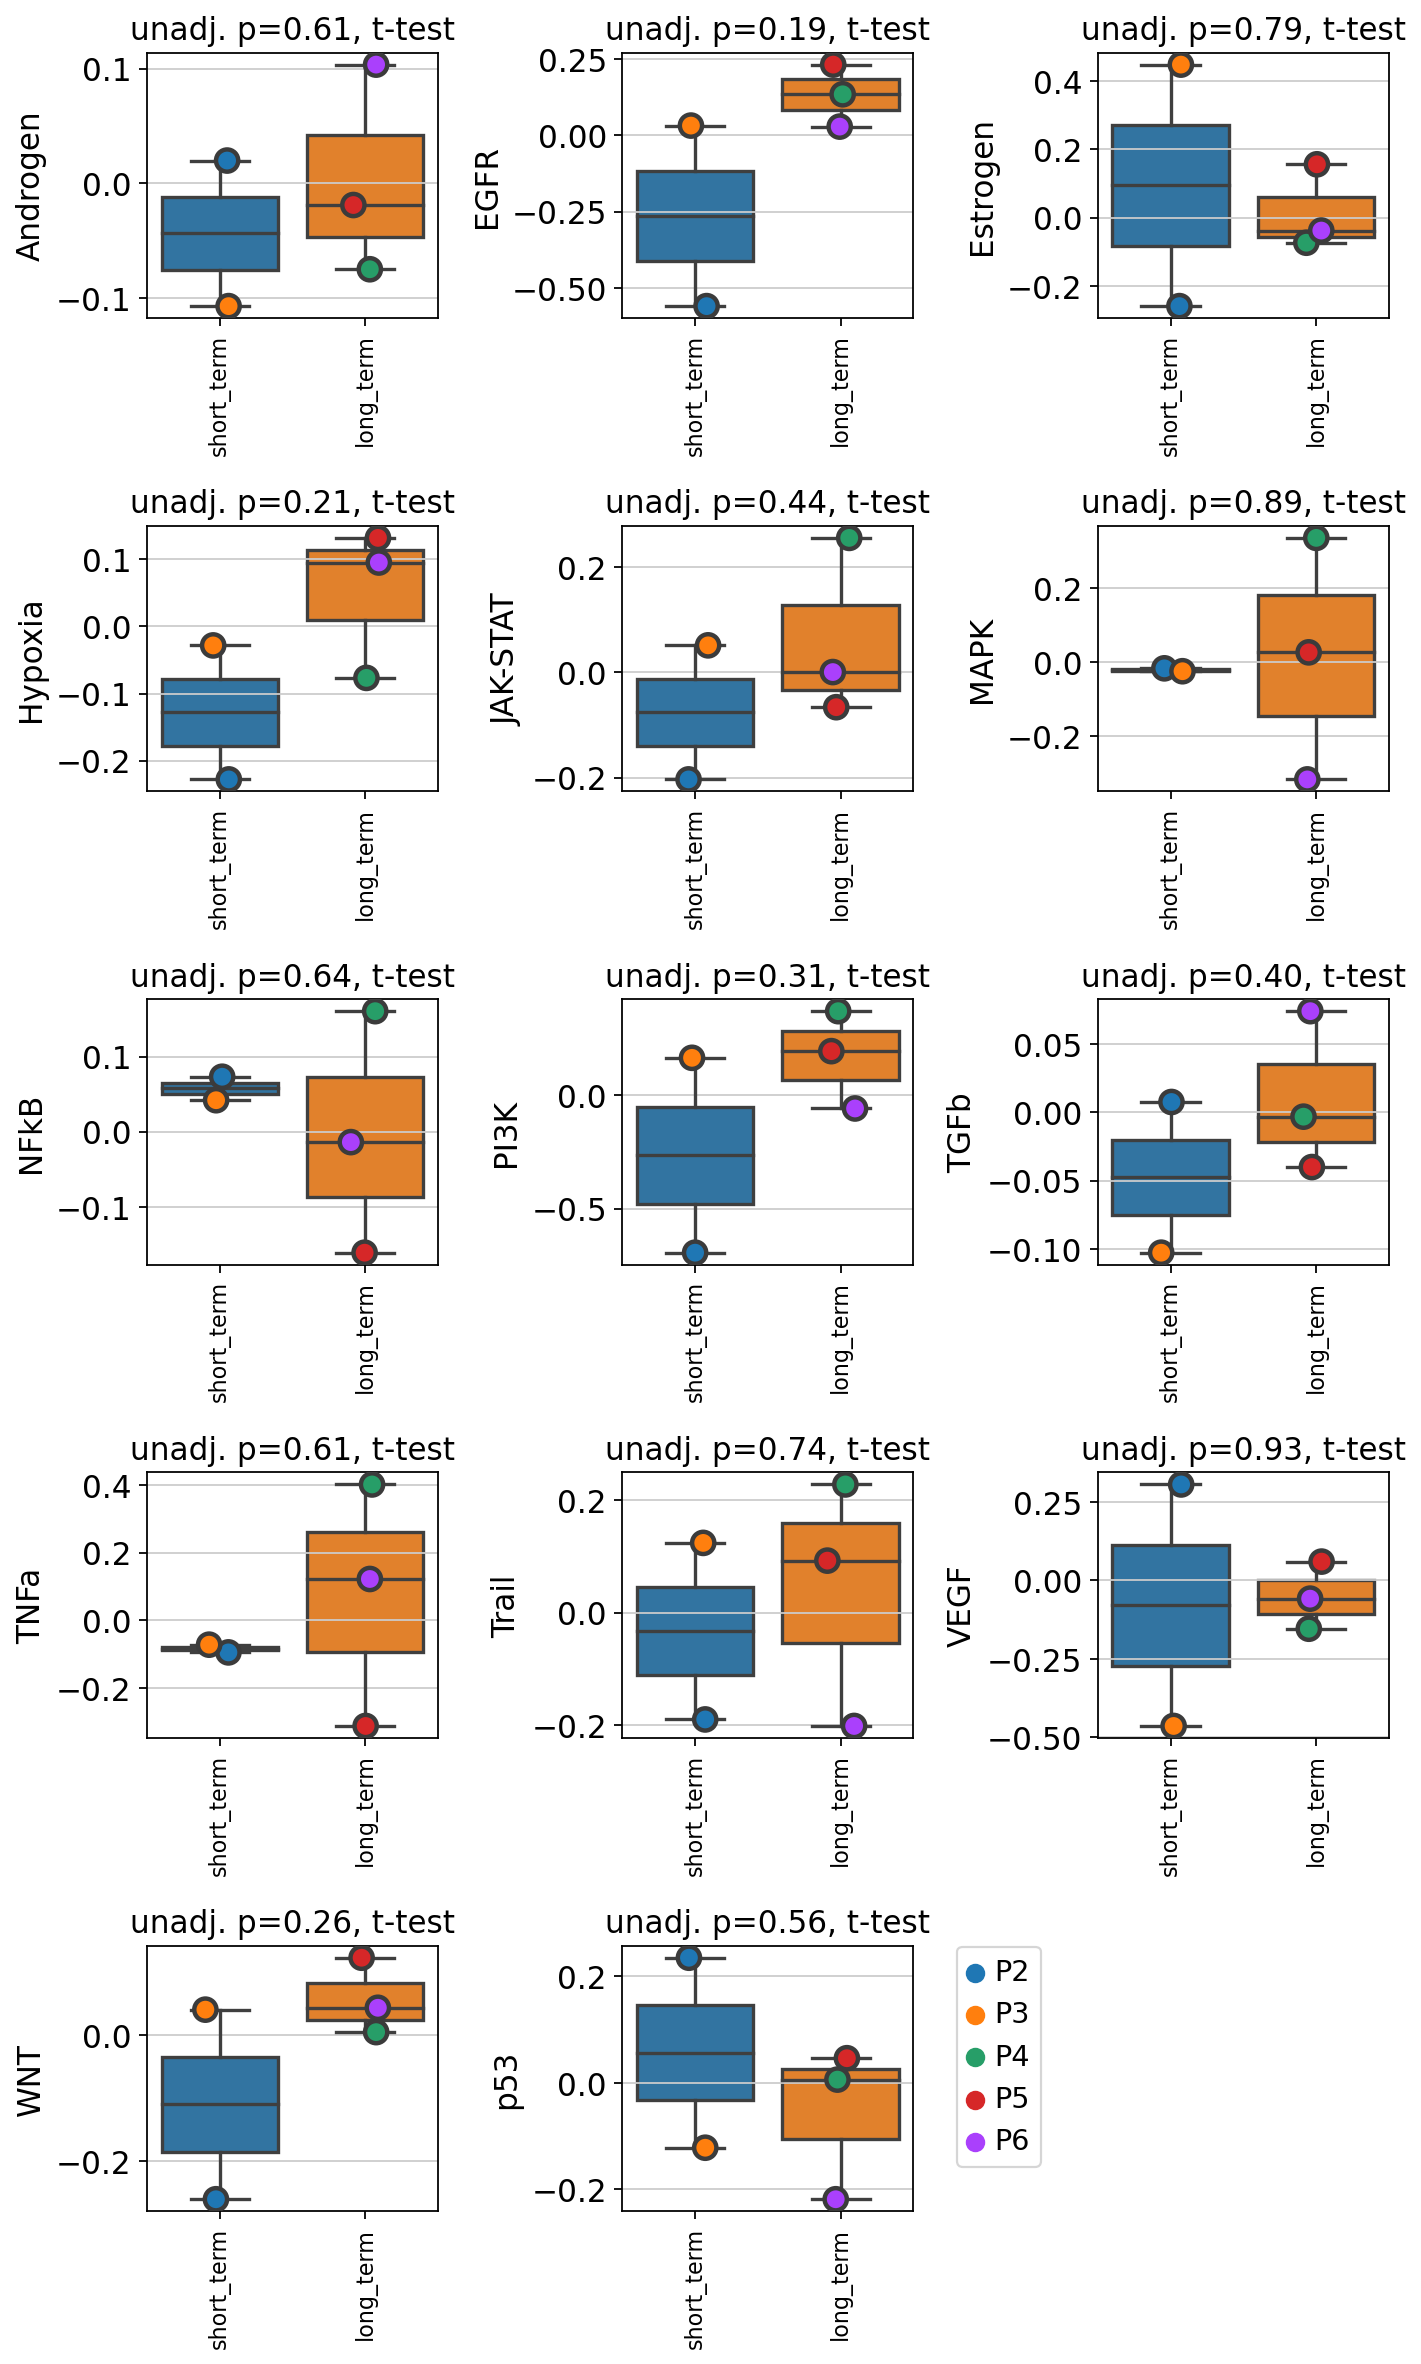

In [49]:
fig, axes = plt.subplots(5, 3, figsize=(3 * 3, 5 * 3), tight_layout=True)
axes = axes.flatten()
for pw, ax in zip(adata_pw.var.index, axes):
    sns.stripplot(
        x="response",
        data=progeny_by_patient_melt.query(f"pathway == '{pw}'"),
        y="progeny_score",
        ax=ax,
        hue="patient",
        size=10,
        linewidth=2,
    )
    sns.boxplot(
        x="response",
        data=progeny_by_patient_melt.query(f"pathway == '{pw}'"),
        y="progeny_score",
        ax=ax,
    )
    ax.set_xlabel("")
    ax.tick_params(axis="x", rotation=90, labelsize=10)
    ax.legend().set_visible(False)
    ax.set_ylabel(pw)
    ax.set_title("unadj. p={:.2f}, t-test".format(pval_dict[pw]))
axes[-1].set_visible(False)
axes[-2].legend().set_visible(True)
axes[-2].legend(bbox_to_anchor=(1.1, 1.05))
fig.tight_layout()
plt.show()

### matrixplot by response

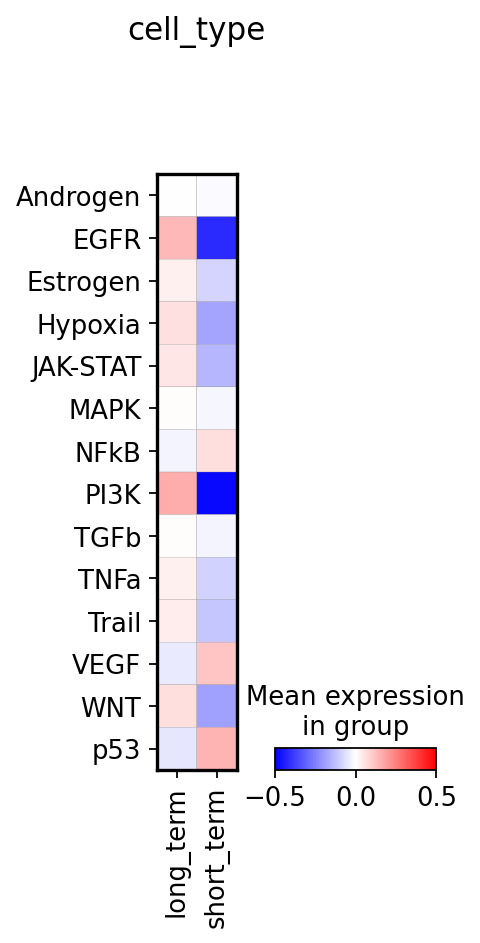

In [50]:
sc.pl.matrixplot(
    adata_pw,
    var_names=adata.obsm["progeny"].columns,
    groupby="response",
    swap_axes=True,
    cmap="bwr",
    title="cell_type",
    vmin=-0.5,
    vmax=0.5,
)

### matrixplot by patient

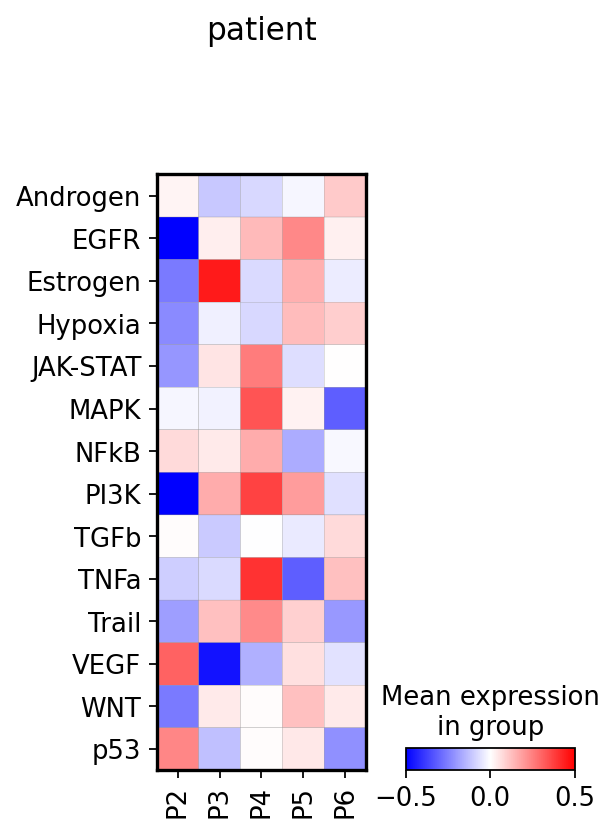

In [51]:
sc.pl.matrixplot(
    adata_pw,
    var_names=adata.obsm["progeny"].columns,
    groupby="patient",
    swap_axes=True,
    cmap="bwr",
    title="patient",
    vmin=-0.5,
    vmax=0.5,
)